In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras import initializers, layers
from datetime import date
from sklearn.model_selection import train_test_split
import seaborn as sns
import umap
import umap.plot
from scipy import stats

2023-06-26 17:40:18.827730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/xbzheng/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xtrain = r"./dataSC/NEW_training_sample.csv.gz"
ytrain = r"./dataSC/NEW_training_label.csv.gz"
xtest = r"./dataSC/NEW_testing_sample.csv.gz"
ytest = r"./dataSC/NEW_testing_label.csv.gz"

i=0
samplesdf = pd.read_csv(xtrain,compression ="gzip",delimiter=',')
x_train = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytrain,compression ="gzip",delimiter=',')
y_train = samplesdf.to_numpy()
'''
y_train = np.zeros((x_train.shape[0],2))
for yt in y_trai:
    if yt == 0:
        y_train[i] = [1,0]
    else:
        y_train[i] = [0,1]
    i = i + 1
'''
samplesdf = pd.read_csv(xtest,compression ="gzip",delimiter=',')
x_test = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytest,compression ="gzip",delimiter=',')
y_test = samplesdf.to_numpy()
'''
y_test = np.zeros((x_test.shape[0],2))
i = 0
for yt in y_tes:
    if yt == 0:
        y_test[i] = [1,0]
    else:
        y_test[i] = [0,1]
    i = i + 1
'''

print("done")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




done
(38483, 3030)
(38483, 1)
(4265, 3030)
(4265, 1)


In [3]:
common_indicator = pd.read_csv('./dataBulk/common_rna_indicator.csv',index_col=0).values.squeeze().tolist()

x_train = x_train.T[common_indicator].T
print(x_train.shape)
x_test = x_test.T[common_indicator].T
print(x_test.shape)

(38483, 2869)
(4265, 2869)


In [4]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name="safe_norm"):
    
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

def visualize_convcaps(caps_and_routing, caps_and_routing_dims, reduce):

    temp_dims = caps_and_routing_dims[0:2] + [1]*(len(caps_and_routing_dims)-2)
    convcaps_lengths = tf.reshape(safe_norm(caps_and_routing[0], axis=-1), temp_dims)
    temp_dims = [1]*(2) + caps_and_routing_dims[2:len(caps_and_routing_dims)]
    convcaps_lengths_tiled = tf.tile(convcaps_lengths, temp_dims)

    temp_dims = caps_and_routing_dims[0:3] + [1]*(len(caps_and_routing_dims)-3)
    routing1_reshape = tf.reshape(caps_and_routing[1], temp_dims)
    temp_dims = [1]*(3) + caps_and_routing_dims[3:len(caps_and_routing_dims)]
    routing1_reshape_tiled = tf.tile(routing1_reshape, temp_dims)

    temp_dims = [1, 1, caps_and_routing_dims[2]] + [1]*(len(caps_and_routing_dims)-3)
    caps1_lengths = tf.reshape(safe_norm(caps_and_routing[2], axis=-1),  temp_dims)
    temp_dims = caps_and_routing_dims[0:2] + [1] + caps_and_routing_dims[3:len(caps_and_routing_dims)]
    caps1_lengths_tiled = tf.tile(caps1_lengths, temp_dims)

    temp1 = tf.square(tf.multiply(routing1_reshape_tiled, caps1_lengths_tiled))

    all_paths = tf.multiply(convcaps_lengths_tiled, temp1)

    normalizing_factor = np.prod(caps_and_routing_dims[1:len(caps_and_routing_dims)])
    all_paths_average = tf.reduce_sum(all_paths, axis=reduce)/normalizing_factor
            
    return all_paths_average

In [5]:
model = keras.models.load_model('./model/weightmodel')
model.summary()

2023-06-26 17:40:44.211543: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-26 17:40:44.212214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-26 17:40:44.266737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2023-06-26 17:40:44.267006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:73:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 715.34GiB/s
2023-06-26 17:40:44.267037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-26 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2869, 1)]         0         
_________________________________________________________________
weightlayer (Weightlayer)    ((None, 2869, 8), (1, 286 22952     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 2869, 8)           0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 2869, 8)           0         
_________________________________________________________________
groupcaps (CapsuleLayer)     ((None, 20, 16), (None, 2 7344640   
_________________________________________________________________
transformer_block (Transform (None, 20, 16)            5392      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0     

In [6]:
SquashOut = models.Model(inputs=model.input, outputs=model.get_layer('primarycap_squash').output) 
RoutingOut = models.Model(inputs=model.input, outputs=model.get_layer('groupcaps').output)

# Weight of First Layer

In [7]:
weight1 = model.get_layer('weightlayer').get_weights()[0]
channelweight = weight1.squeeze()
weight_hp = abs(channelweight)>0.075
flag_hp = np.any(weight_hp,axis = 1)
weight_hp = channelweight[flag_hp,:]
weight_hp.shape

(53, 8)

In [8]:
rna_names = pd.read_csv('./dataBulk/common_rna.csv',index_col = 0).values.squeeze()

/tmp/ipykernel_3422353/2927182887.py:4: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


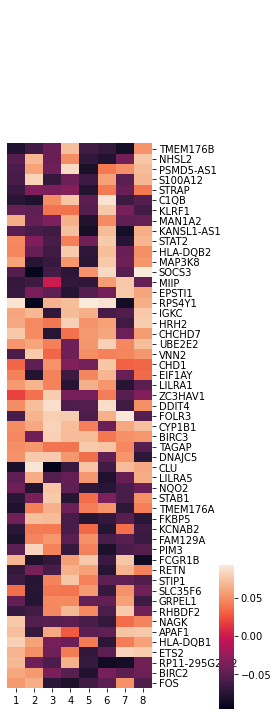

In [9]:
cg = sns.clustermap(weight_hp, annot=False, col_cluster=False, figsize=(4, 10), 
               xticklabels=np.arange(1,9),yticklabels=rna_names[flag_hp], cbar_pos=(0.9, 0.01, 0.05, 0.2))
cg.ax_row_dendrogram.set_visible(False)
plt.tight_layout()
# plt.savefig('./figures/weightHeatmap.svg',dpi=100)
plt.show()

In [10]:
channel_rna = []
for i in range(len(channelweight[0,:])):
    flag = abs(channelweight[:,i])>0.060
    channel_rna.append(rna_names[flag].tolist())
channel_rna

[['GNB1',
  'KCNAB2',
  'RBP7',
  'MAD2L2',
  'MIIP',
  'TNFRSF1B',
  'UBR4',
  'C1QA',
  'C1QB',
  'YTHDF2',
  'TRAPPC3',
  'MACF1',
  'MAN1A2',
  'FCGR1B',
  'ENSA',
  'S100A9',
  'TAGLN2',
  'RC3H1',
  'RFWD2',
  'NPL',
  'FAM129A',
  'MDM4',
  'CD55',
  'RP11-295G20.2',
  'TOMM20',
  'KIDINS220',
  'MPV17',
  'DPY30',
  'PPM1B',
  'ERLEC1',
  'NAGK',
  'RNF149',
  'SLC20A1',
  'MARCO',
  'ARL6IP6',
  'WIPF1',
  'NBEAL1',
  'PNKD',
  'CTDSP1',
  'SP100',
  'INPP5D',
  'AZI2',
  'TGFBR2',
  'CTNNB1',
  'RASSF1',
  'STAB1',
  'BBX',
  'GYG1',
  'BCL6',
  'LAP3',
  'DHX15',
  'FRYL',
  'ZNF330',
  'ACSL1',
  'PTGER4',
  'ANXA2R',
  'DHX29',
  'BDP1',
  'POLK',
  'AGGF1',
  'PPIP5K2',
  'HSPA4',
  'TXNDC15',
  'TMEM173',
  'DIAPH1',
  'CD74',
  'DUSP1',
  'HRH2',
  'SQSTM1',
  'PRPF4B',
  'LY86',
  'TMEM14B',
  'SOX4',
  'FAM65B',
  'HLA-DQB1',
  'PIM1',
  'MRPL2',
  'OGFRL1',
  'SENP6',
  'AMD1',
  'BCLAF1',
  'ARL4A',
  'VOPP1',
  'WBSCR22',
  'TMEM60',
  'CD36',
  'TMEM176B',
  'TMEM

In [11]:
df = pd.DataFrame()
a = [len(channel_rna[i]) for i in range(8)]
maxlen = max(a)
for i in range(8):
    for _ in range(maxlen-len(channel_rna[i])):
        channel_rna[i].append('')
    df['Channel'+str(i+1)] = channel_rna[i]
df

Channel1 Channel2 Channel3 Channel4 Channel5 Channel6 Channel7  Channel8
0       GNB1     MIIP     MIB2     NADK     NADK   KCNAB2     MIIP    KCNAB2
1     KCNAB2     UBR4    FBXO6     GNB1     GNB1     C1QB     C1QB  TNFRSF1B
2       RBP7     C1QB  KHDRBS1     MIIP     MIIP   ARID1A    PNRC2   RPS6KA1
3     MAD2L2    TM2D1    CSF3R     C1QA     C1QA     RPA2     CD52      IFI6
4       MIIP    GTF2B     PPIE     C1QB    STMN1    MACF1     IFI6      RPA2
..       ...      ...      ...      ...      ...      ...      ...       ...
221                                        DESI1              ETS2          
222                                        NUP50               MX2          
223                                         ETS2             ITGB2          
224                                      PTTG1IP                            
225                                        ITGB2                            

[226 rows x 8 columns]

In [12]:
channel_rnaPlus = []
channel_rnaMin = []
for i in range(len(channelweight[0,:])):
    flag1 = channelweight[:,i]>0.06
    flag2 = channelweight[:,i]<-0.06
    channel_rnaPlus.append(rna_names[flag1].tolist())
    channel_rnaMin.append(rna_names[flag2].tolist())

# Relation between Capsule and RNA

## using one-hot input

In [13]:
cap2rna = np.empty((0,20))
cap2rnaflag = np.empty((0,20))
for i in range(2869):
    x = np.zeros((2869,))
    x[i] = 1
    caps1_output, routing1 = RoutingOut.predict(x.reshape(1,-1))
    capdimsum = np.sum(abs(caps1_output),axis = 2) # sum up all dimensin in each cap
    cap2rnaflag = np.append(cap2rnaflag, (capdimsum==capdimsum.max()), axis = 0)
    cap2rna = np.append(cap2rna, capdimsum,axis = 0)
cap2rna

2023-06-26 17:40:52.709965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-26 17:40:52.710445: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2023-06-26 17:40:52.925938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


array([[1.36574196e-09, 5.25238242e-10, 2.95775349e-10, ...,
        6.49700516e-10, 1.88056876e-10, 9.33989219e-10],
       [1.10999707e-08, 5.90224580e-09, 8.01009890e-08, ...,
        1.55922208e-08, 2.59478519e-08, 9.19642318e-09],
       [8.55346904e-09, 1.57186655e-08, 8.24026847e-10, ...,
        1.29206978e-09, 5.94429084e-09, 5.85037263e-09],
       ...,
       [5.45061667e-08, 6.00705574e-09, 3.06033465e-09, ...,
        2.54844701e-09, 4.21286916e-09, 3.66657922e-08],
       [1.71587558e-07, 3.41025554e-07, 5.23404651e-07, ...,
        2.47193952e-07, 3.44121190e-07, 1.91271909e-07],
       [1.29274191e-08, 1.49620476e-08, 6.85099888e-09, ...,
        1.11271010e-08, 3.69044906e-09, 1.23832926e-08]])

In [14]:
# Significantly greater capsules
z_scores = stats.zscore(cap2rna, axis=1)
pvalues = stats.norm.sf(abs(z_scores))
# np.sum(pvalues<0.01,axis=1)

# Contribute greater 1e-7
# cap2rna_mat = (cap2rna>5e-7) | (pvalues<0.001)
cap2rna_mat = (pvalues<0.001)
cap2rna_mat

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
cap2rna_mat2 = (cap2rna_mat + cap2rnaflag)>0

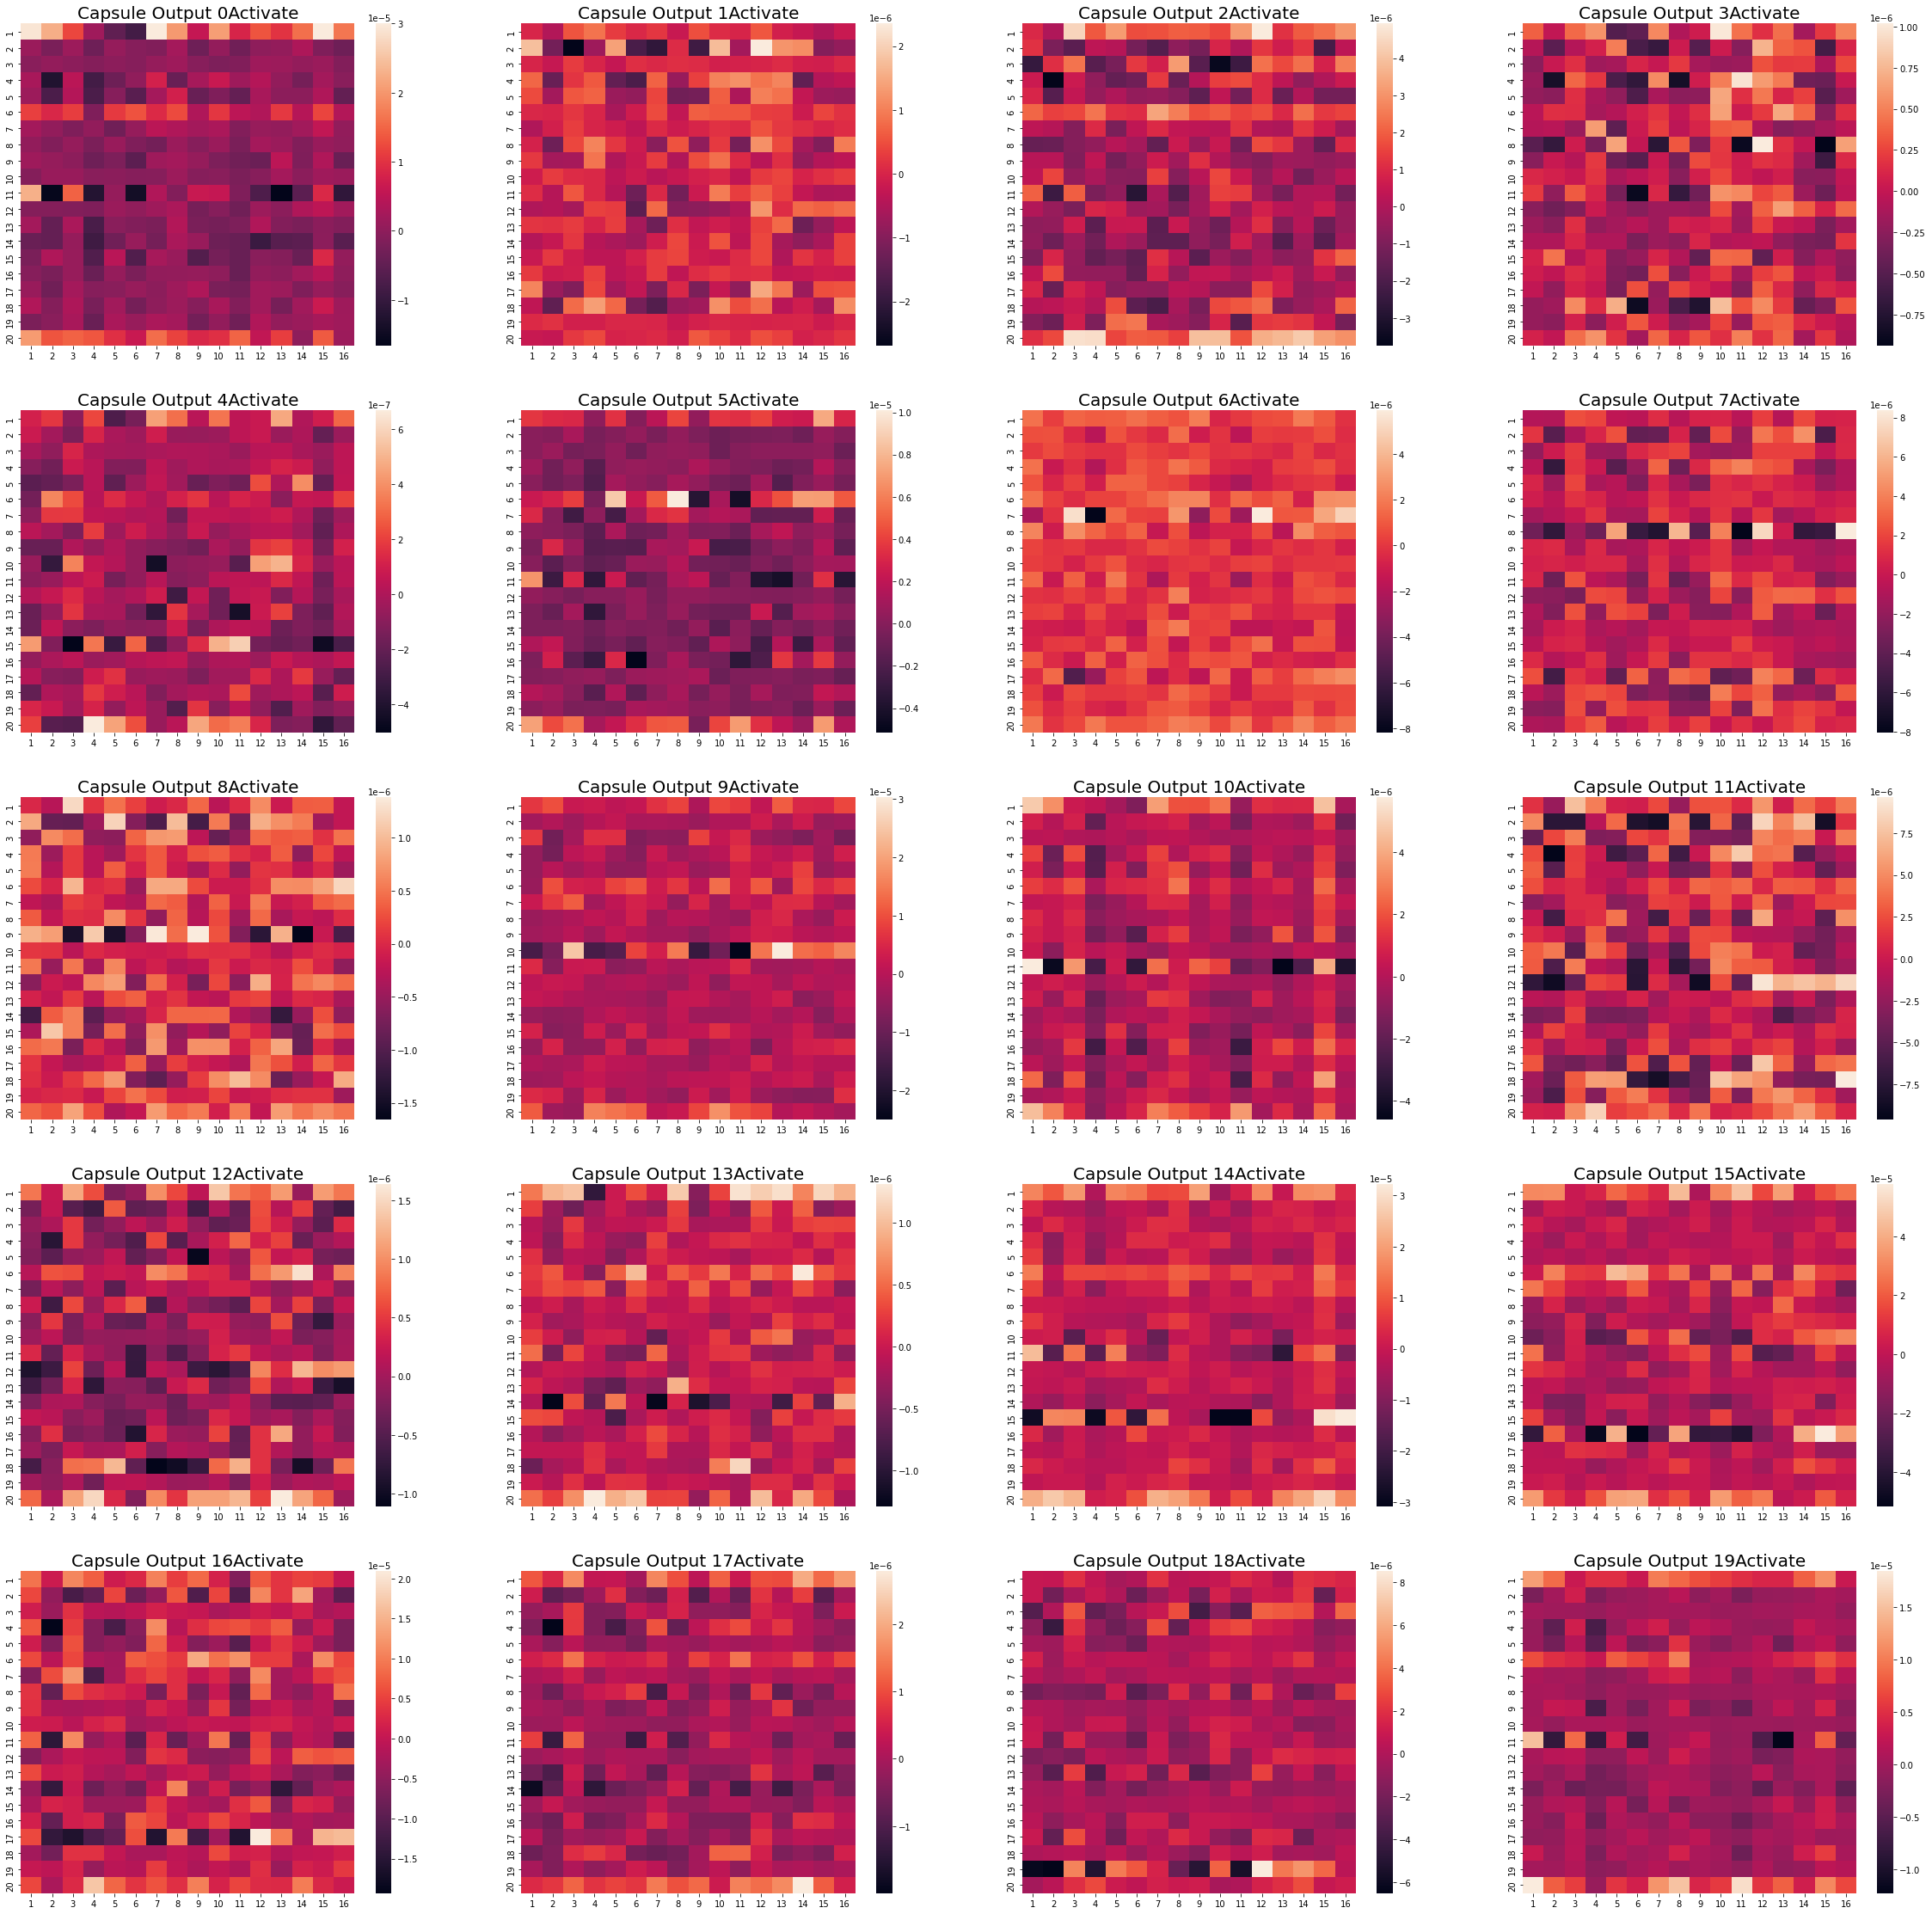

In [19]:
fig = plt.figure(figsize=(40,40))

for i in range(20):
    x = 1.0*cap2rna_mat2[:,i]
    caps1_output, routing1 = RoutingOut.predict(x.reshape(1,-1))
    ax = fig.add_subplot(5,4,i+1)
    sns.heatmap(caps1_output.squeeze(),xticklabels=np.arange(1,17),yticklabels=np.arange(1,21),ax=ax)
    plt.title('Capsule Output '+str(i)+'Activate',fontdict={'fontsize': 20})

filename = './figures/Capheatmap/20Capheatmap1.png'
# plt.savefig(filename,dpi=300)

In [20]:
cap2rnalist1 = []
for i in range(20):
    cap2rnalist1.append(rna_names[cap2rna_mat2[:,i]].tolist())
cap2rnalist1

[['NOC2L',
  'CPSF3L',
  'TARDBP',
  'MIIP',
  'PRDM2',
  'TMEM50A',
  'ARID1A',
  'TAF12',
  'LAPTM5',
  'HDAC1',
  'TRAPPC3',
  'MRPS15',
  'YBX1',
  'GPBP1L1',
  'FUBP1',
  'GBP2',
  'TMED5',
  'PSMA5',
  'DRAM2',
  'RHOC',
  'CD58',
  'APH1A',
  'JTB',
  'TPM3',
  'DPM3',
  'ASH1L',
  'PMF1',
  'CREG1',
  'CEP350',
  'RNPEP',
  'SNRPE',
  'LPGAT1',
  'IARS2',
  'LBR',
  'GUK1',
  'LAPTM4A',
  'HADHA',
  'MPV17',
  'CDC42EP3',
  'RHOQ',
  'RAB1A',
  'PLEK',
  'NFU1',
  'ANXA4',
  'NAGK',
  'DGUOK',
  'POLE4',
  'CAPG',
  'ST3GAL5',
  'INPP4A',
  'COA5',
  'MARCO',
  'MZT2B',
  'UBXN4',
  'HNMT',
  'SP3',
  'ARPC2',
  'TUBA4A',
  'HDLBP',
  'SEPT2',
  'ARPC4',
  'RPL32',
  'NGLY1',
  'LRRFIP2',
  'MYD88',
  'MAPKAPK3',
  'SELK',
  'APPL1',
  'UBA3',
  'COX17',
  'PARP14',
  'ABTB1',
  'RAB7A',
  'MRFAP1',
  'MED28',
  'CHIC2',
  'USO1',
  'HSD17B11',
  'UBE2D3',
  'NDUFC1',
  'TLR2',
  'MARCH1',
  'ACSL1',
  'MRPL36',
  'CCT5',
  'DAP',
  'SUB1',
  'COL4A3BP',
  'AP3B1',
  'SRP19',
 

In [21]:
cap2rnalist = []
for i in range(20):
    cap2rnalist.append(rna_names[cap2rna_mat2[:,i]].tolist())
cap2rnalist

[['NOC2L',
  'CPSF3L',
  'TARDBP',
  'MIIP',
  'PRDM2',
  'TMEM50A',
  'ARID1A',
  'TAF12',
  'LAPTM5',
  'HDAC1',
  'TRAPPC3',
  'MRPS15',
  'YBX1',
  'GPBP1L1',
  'FUBP1',
  'GBP2',
  'TMED5',
  'PSMA5',
  'DRAM2',
  'RHOC',
  'CD58',
  'APH1A',
  'JTB',
  'TPM3',
  'DPM3',
  'ASH1L',
  'PMF1',
  'CREG1',
  'CEP350',
  'RNPEP',
  'SNRPE',
  'LPGAT1',
  'IARS2',
  'LBR',
  'GUK1',
  'LAPTM4A',
  'HADHA',
  'MPV17',
  'CDC42EP3',
  'RHOQ',
  'RAB1A',
  'PLEK',
  'NFU1',
  'ANXA4',
  'NAGK',
  'DGUOK',
  'POLE4',
  'CAPG',
  'ST3GAL5',
  'INPP4A',
  'COA5',
  'MARCO',
  'MZT2B',
  'UBXN4',
  'HNMT',
  'SP3',
  'ARPC2',
  'TUBA4A',
  'HDLBP',
  'SEPT2',
  'ARPC4',
  'RPL32',
  'NGLY1',
  'LRRFIP2',
  'MYD88',
  'MAPKAPK3',
  'SELK',
  'APPL1',
  'UBA3',
  'COX17',
  'PARP14',
  'ABTB1',
  'RAB7A',
  'MRFAP1',
  'MED28',
  'CHIC2',
  'USO1',
  'HSD17B11',
  'UBE2D3',
  'NDUFC1',
  'TLR2',
  'MARCH1',
  'ACSL1',
  'MRPL36',
  'CCT5',
  'DAP',
  'SUB1',
  'COL4A3BP',
  'AP3B1',
  'SRP19',
 

In [22]:
# with open('./figures/data/cap2rnalist.txt','w') as f:
#     for i in cap2rnalist:
#         f.writelines(','.join(i))
#         f.write('\n')

## Umap of capsules

In [23]:
mapper = umap.UMAP().fit(x_train)

In [24]:
y_label = ['case' if i==1 else 'control' for i in y_train.squeeze() ]

<AxesSubplot:>

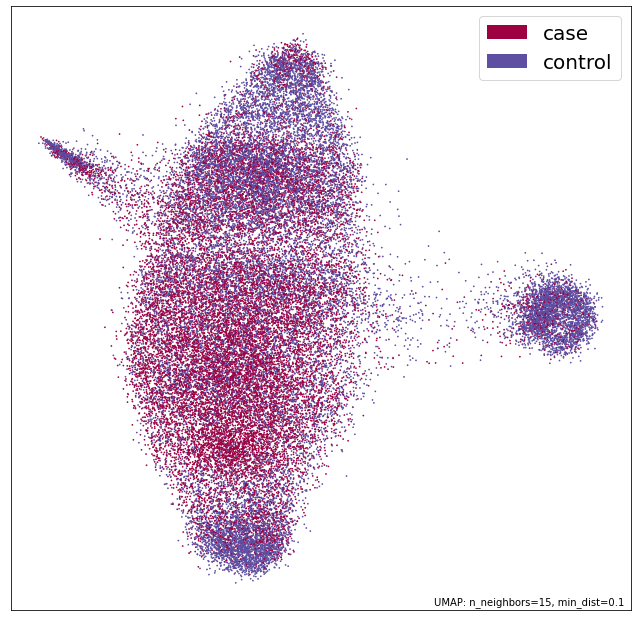

In [25]:
plt.rc('legend', fontsize=20)
umap.plot.points(mapper, labels=np.array(y_label))

# plt.savefig('./figures/umap_sc_label.png',dpi=600)

In [26]:
meta = pd.read_csv('./dataSC/NEW_training_meta.csv')
meta

0     1    2          3     4       5
0      GCGCGATCACTGTGTA-11  Mono  MS2    Control  CD45    P02H
1      TTTCCTCAGTTGAGTA-11     T  TS2    Control  CD45    P02H
2      GTCTCGTTCCGCATAA-28  Mono  MS3    ICU-SEP    DC    P669
3      ACGGGCTTCATGTAGC-11     T  TS3   Leuk-UTI  CD45     P03
4      CGGCTAGTCTCCAGGG-17  Mono  MS1        URO  CD45   C2P21
...                    ...   ...  ...        ...   ...     ...
38478  TAGCCGGGTAGCAAAT-13  Mono  MS2    Control  CD45  C2P07H
38479  CATCCACAGATGTTAG-13    NK  NS1    Control  CD45  C2P05F
38480  ACCTTTATCAGCTGGC-11     T  TS3   Leuk-UTI  CD45     P03
38481  CGCCAAGCACAGAGGT-15  Mono  MS3    Control  CD45  C2P13F
38482  ACAGCTAGTATAGGTA-19    NK  NS1  ICU-NoSEP  CD45    P635

[38483 rows x 6 columns]

<AxesSubplot:>

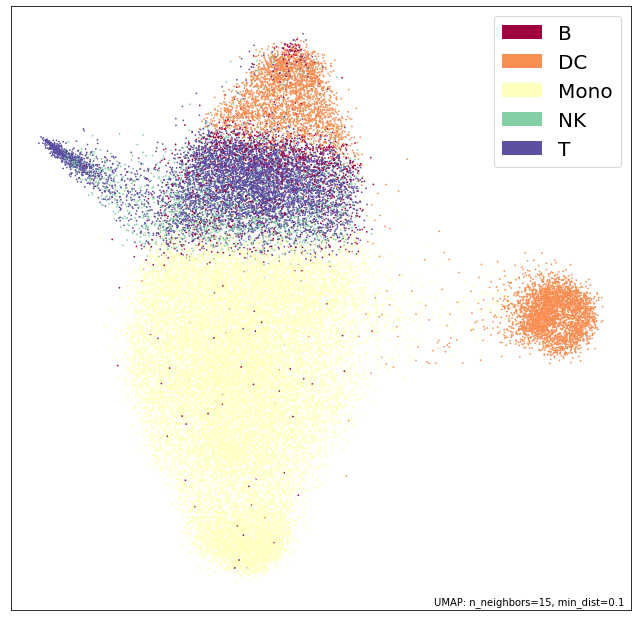

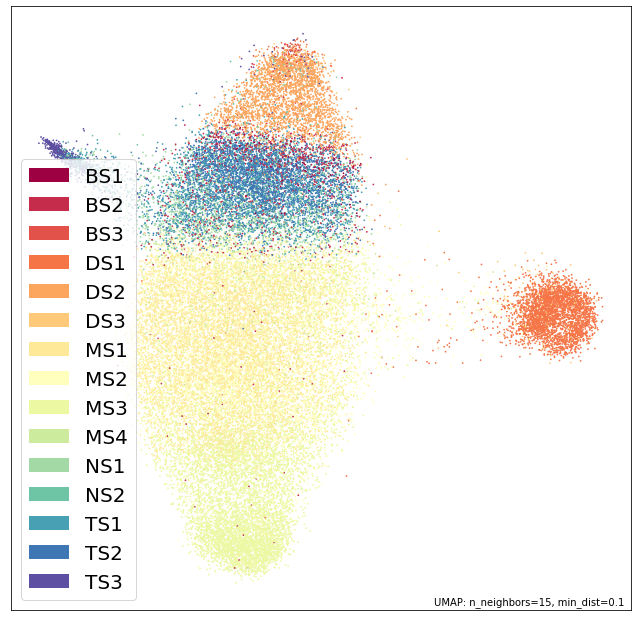

In [27]:
umap.plot.points(mapper, labels=meta[str(1)].values)
# plt.savefig('./figures/umap_sc_celltype.png',dpi=600)
umap.plot.points(mapper, labels=meta[str(2)].values)
# plt.savefig('./figures/umap_sc_cellstate.png',dpi=600)

In [28]:
res = np.empty(shape=(0,20,16))
Rweight = np.empty(shape=(0,20, 2869))
for i in range(len(x_train)//1000+1):
    if i*1000+1000 > len(x_train):
        j = len(x_train)
    else:
        j = i*1000+1000
    caps1_output, routing1 = RoutingOut.predict(x_train[i*1000:j])
    res = np.append(res,caps1_output,axis=0)
    Rweight = np.append(Rweight, routing1.squeeze(), axis=0)
    print("{}/{}".format(i,len(x_train)//1000+1))

0/39
1/39
2/39
3/39
4/39
5/39
6/39
7/39
8/39
9/39
10/39
11/39
12/39
13/39
14/39
15/39
16/39
17/39
18/39
19/39
20/39
21/39
22/39
23/39
24/39
25/39
26/39
27/39
28/39
29/39
30/39
31/39
32/39
33/39
34/39
35/39
36/39
37/39
38/39


<AxesSubplot:>

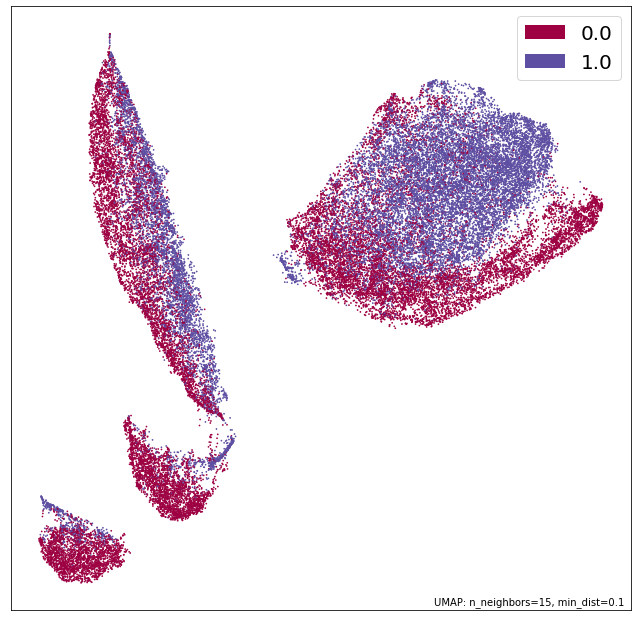

In [29]:
Rweight_mean = np.mean(Rweight,axis = 2)
mapper = umap.UMAP().fit(Rweight_mean)
umap.plot.points(mapper, labels=y_train.squeeze())

In [30]:
res.shape

(38483, 20, 16)

<AxesSubplot:>

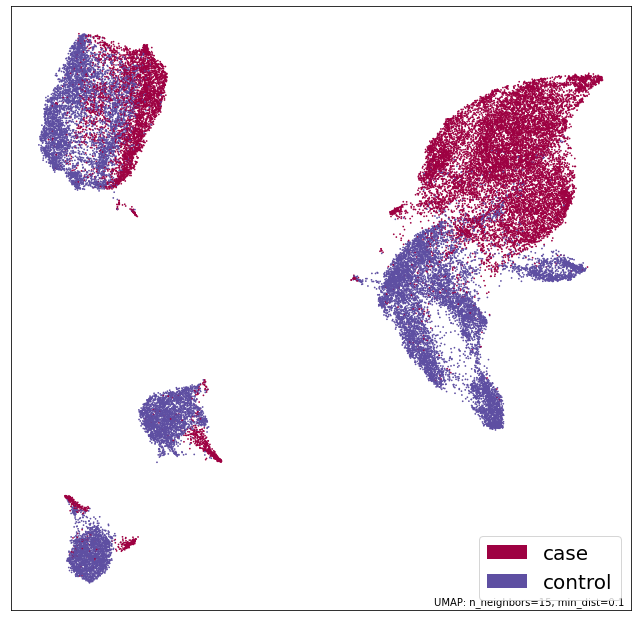

In [31]:
capsOutput = res.reshape(len(res),-1)
mapper = umap.UMAP().fit(capsOutput)
umap.plot.points(mapper, labels=np.array(y_label))
# plt.savefig('./figures/umap_Cap_sc_label.png',dpi=600)

<AxesSubplot:>

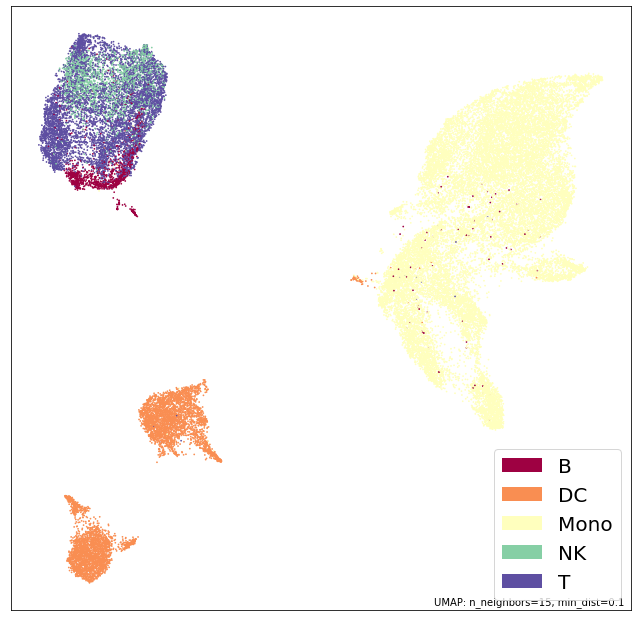

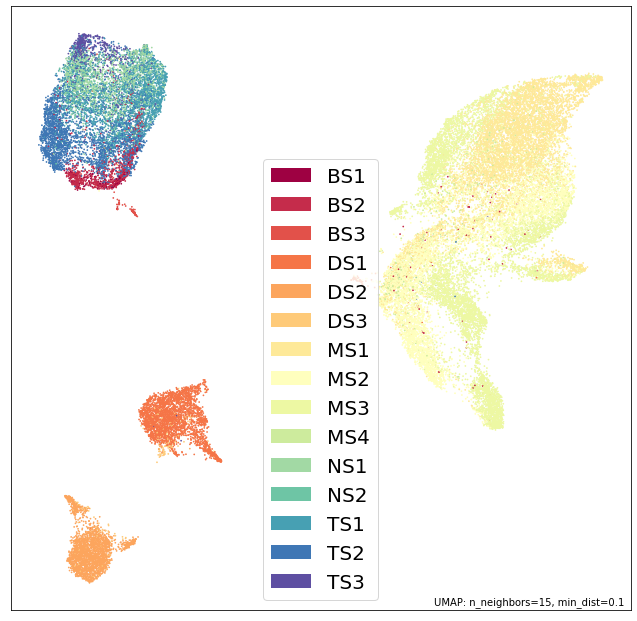

In [32]:
umap.plot.points(mapper, labels=meta[str(1)].values)
# plt.savefig('./figures/umap_Cap_sc_celltype.png',dpi=600)
umap.plot.points(mapper, labels=meta[str(2)].values)
# plt.savefig('./figures/umap_Cap_sc_cellstate.png',dpi=600)

In [33]:
mappers = list()
for i in range(16):
    res2 = res[:,:,i]
    mapper = umap.UMAP().fit(res2)
    mappers.append(mapper)

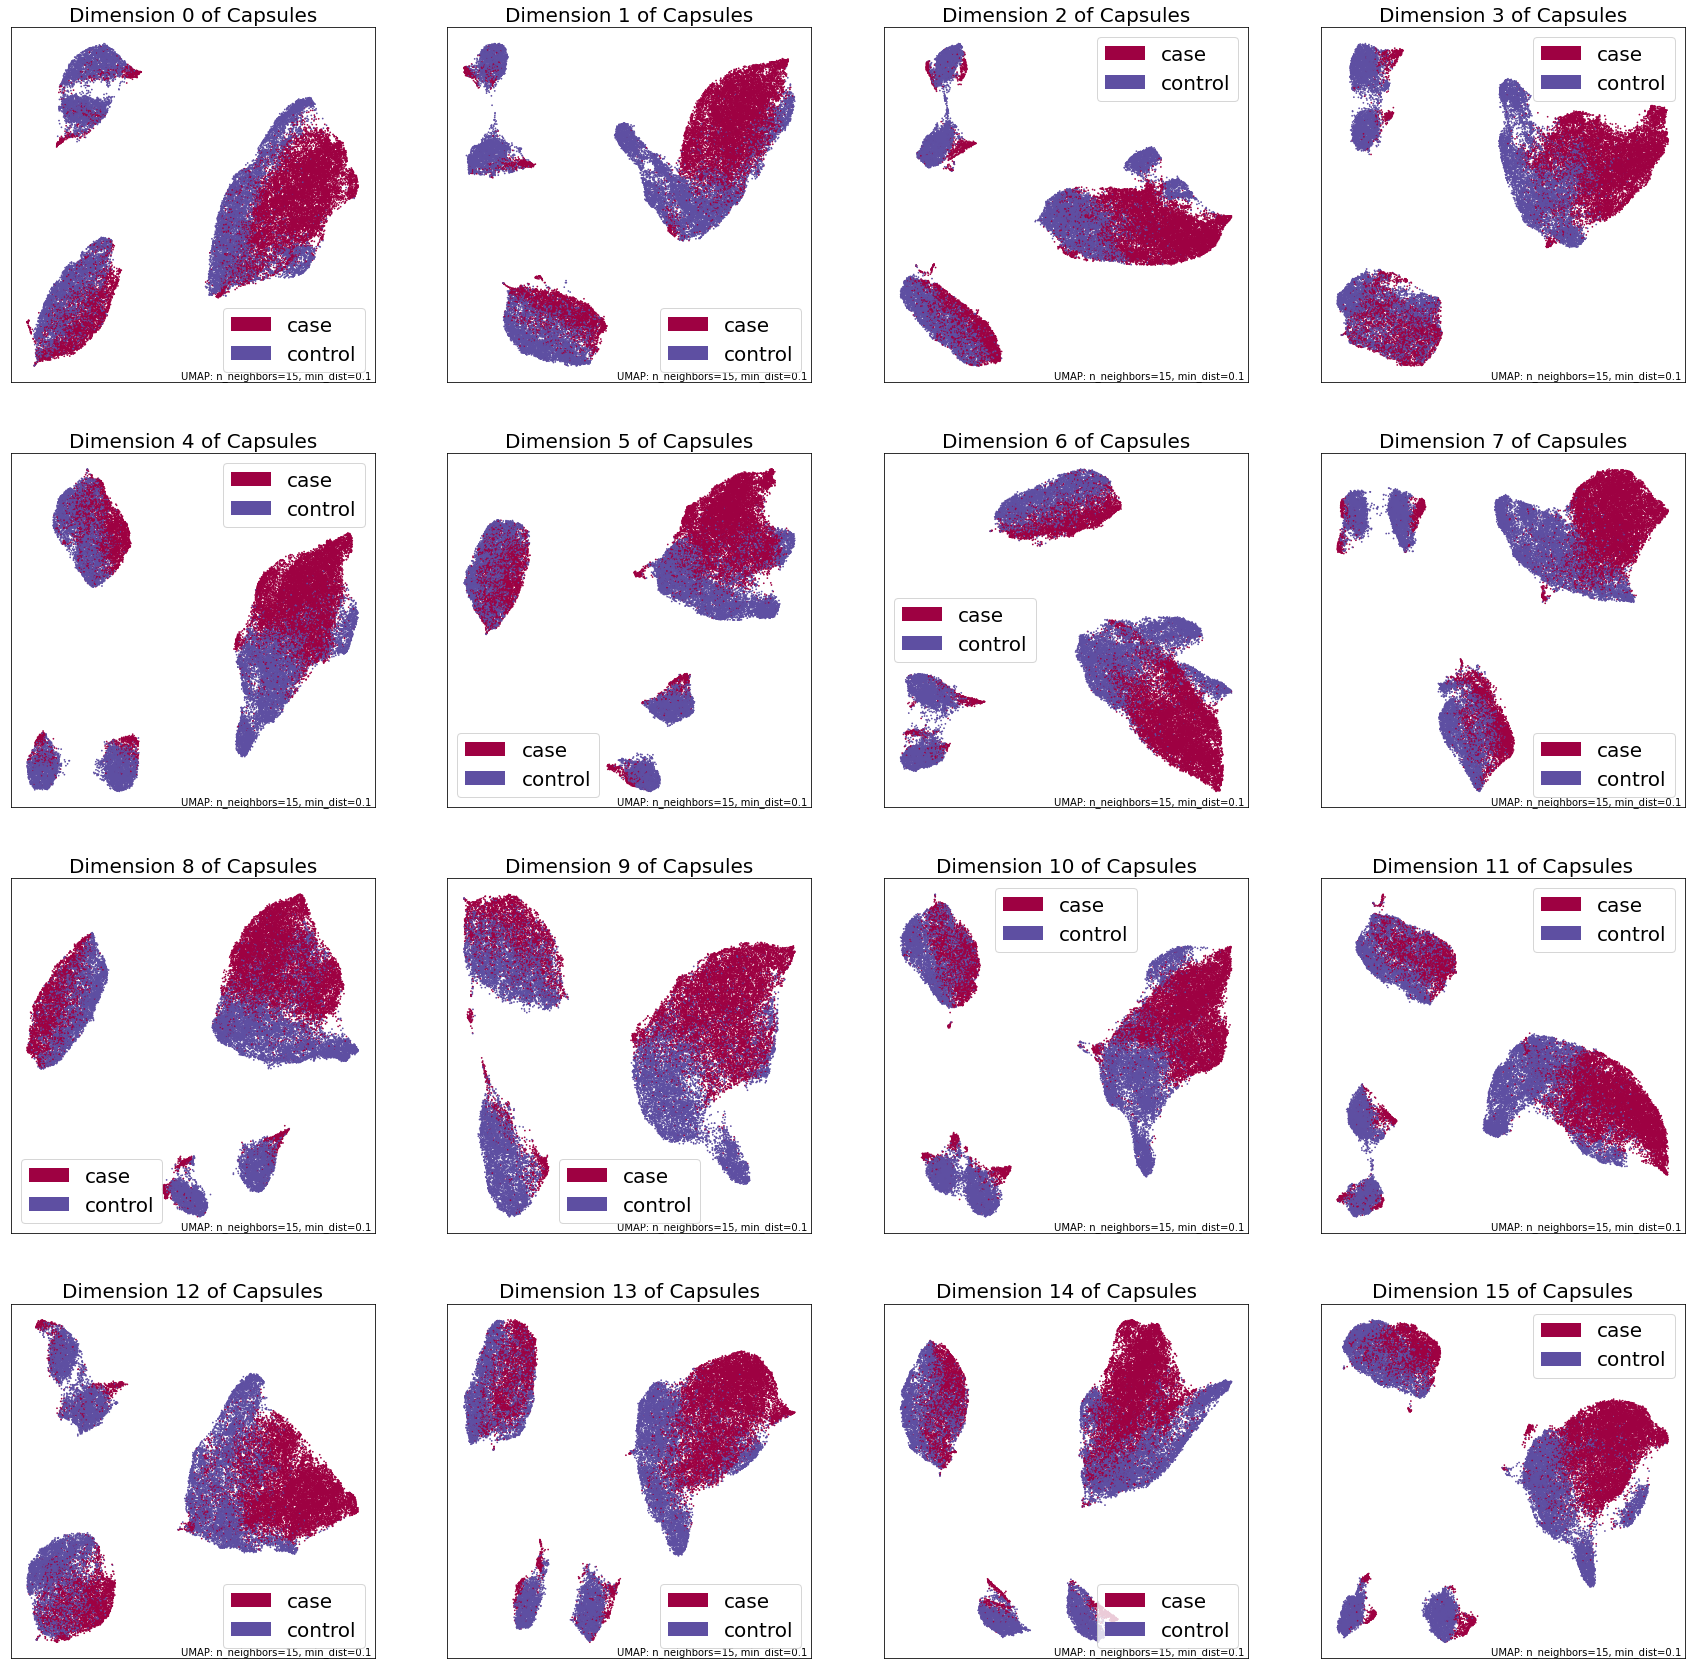

In [34]:
# 16 dimensions
fig = plt.figure(figsize=(30,30))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    umap.plot.points(mappers[i], labels=np.array(y_label),ax=ax)
    plt.title('Dimension '+str(i)+' of Capsules',fontdict={'fontsize': 20})
    
# fig.savefig('./figures/umap_Cap16D_label.png',dpi=100)
plt.show()

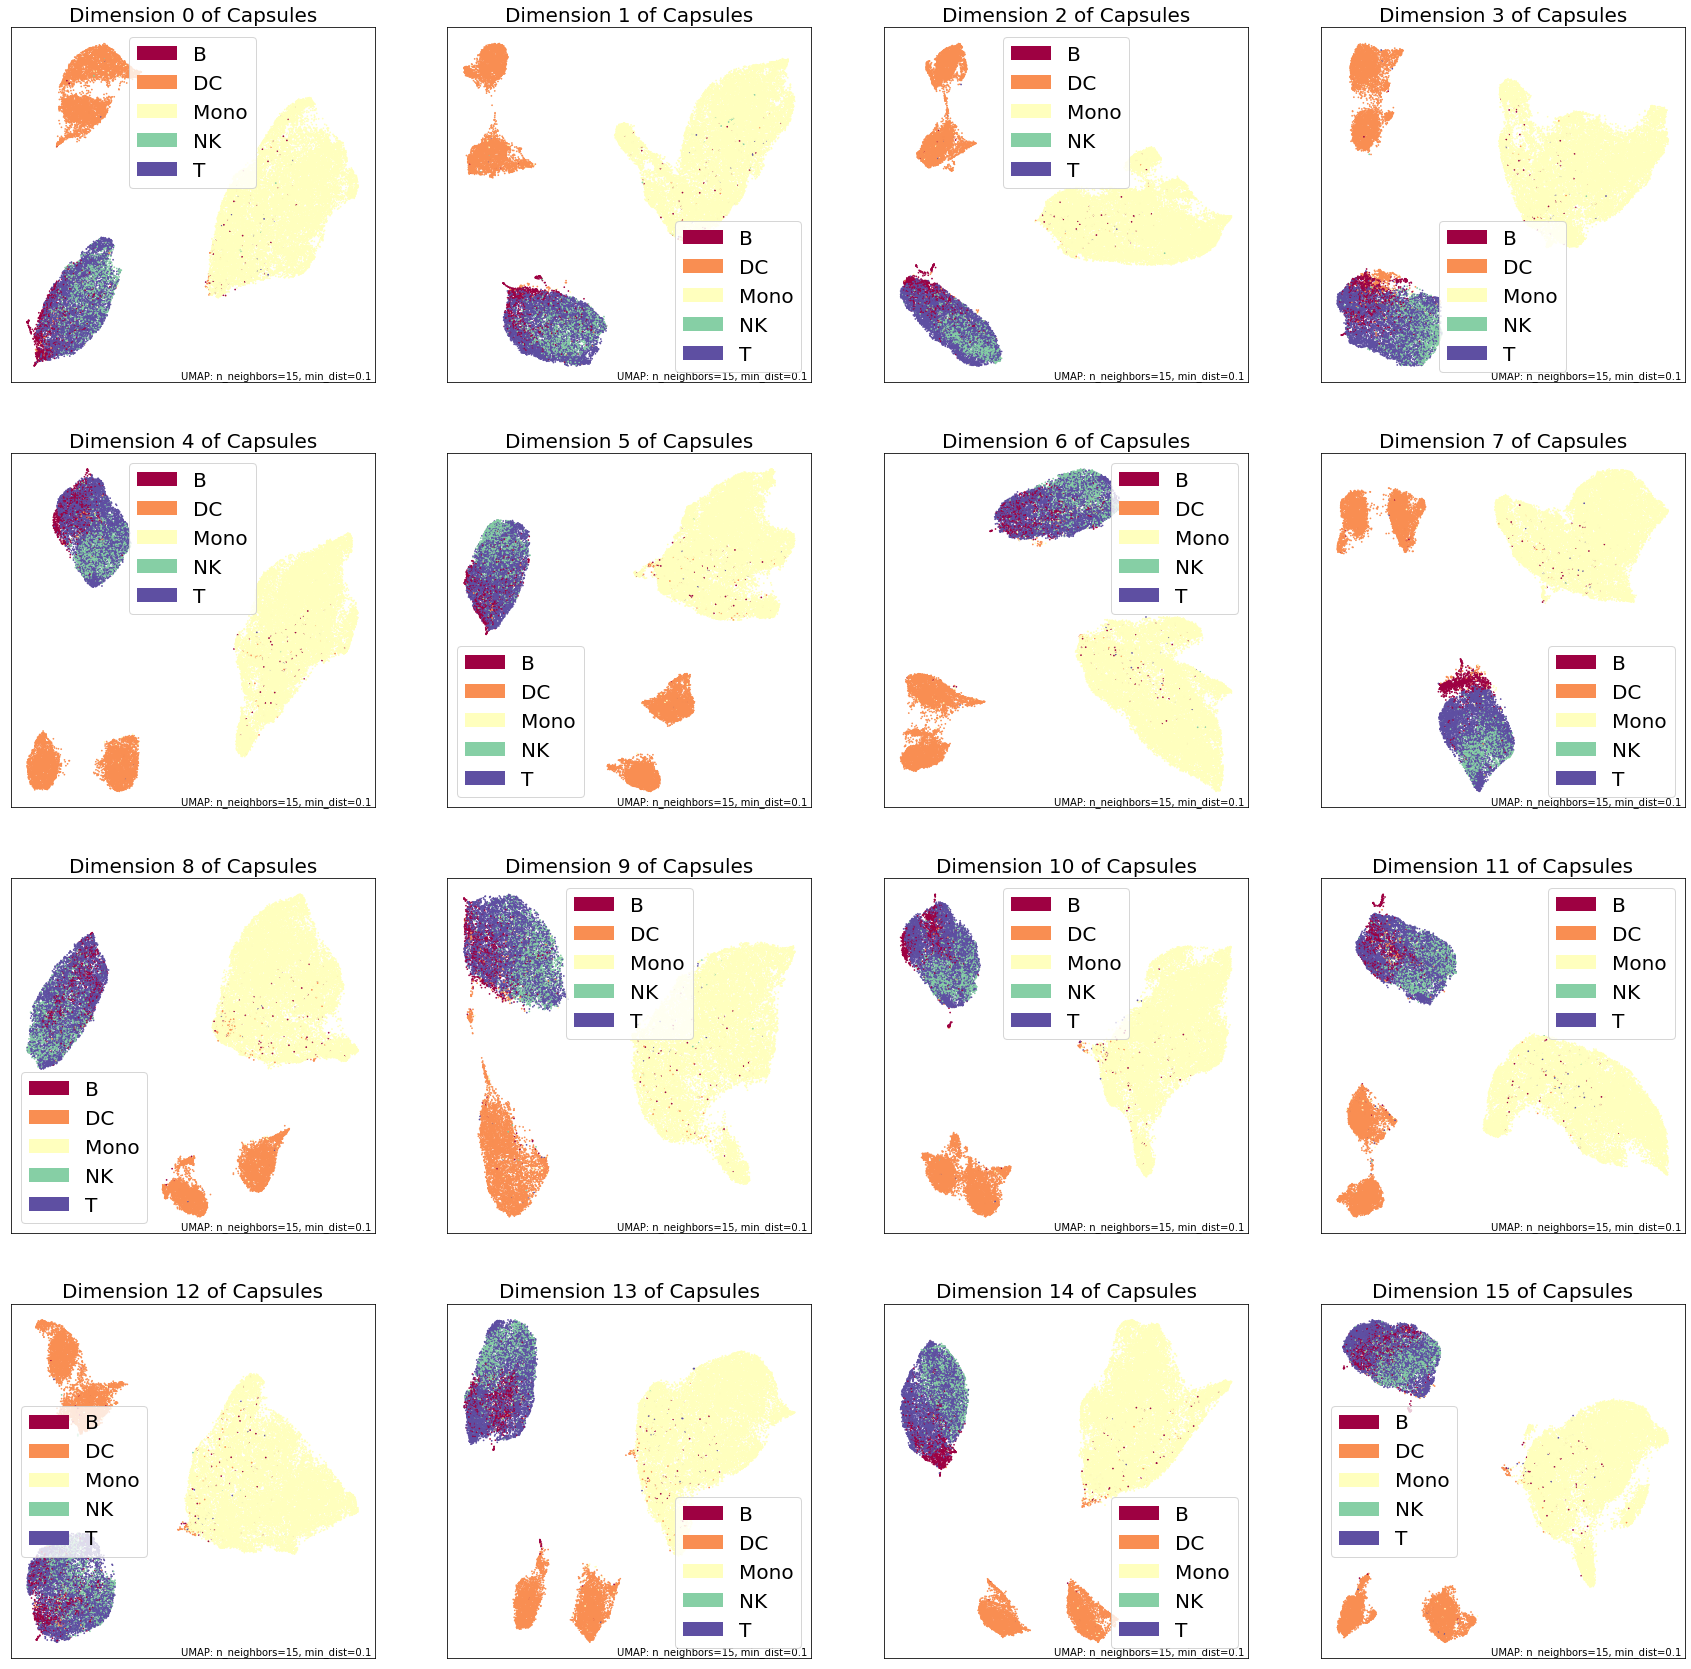

In [35]:
fig = plt.figure(figsize=(30,30))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    umap.plot.points(mappers[i], labels=meta[str(1)].values,ax=ax)
    plt.title('Dimension '+str(i)+' of Capsules',fontdict={'fontsize': 20})
    
# fig.savefig('./figures/umap_Cap16D_celltype.png',dpi=100)
plt.show()

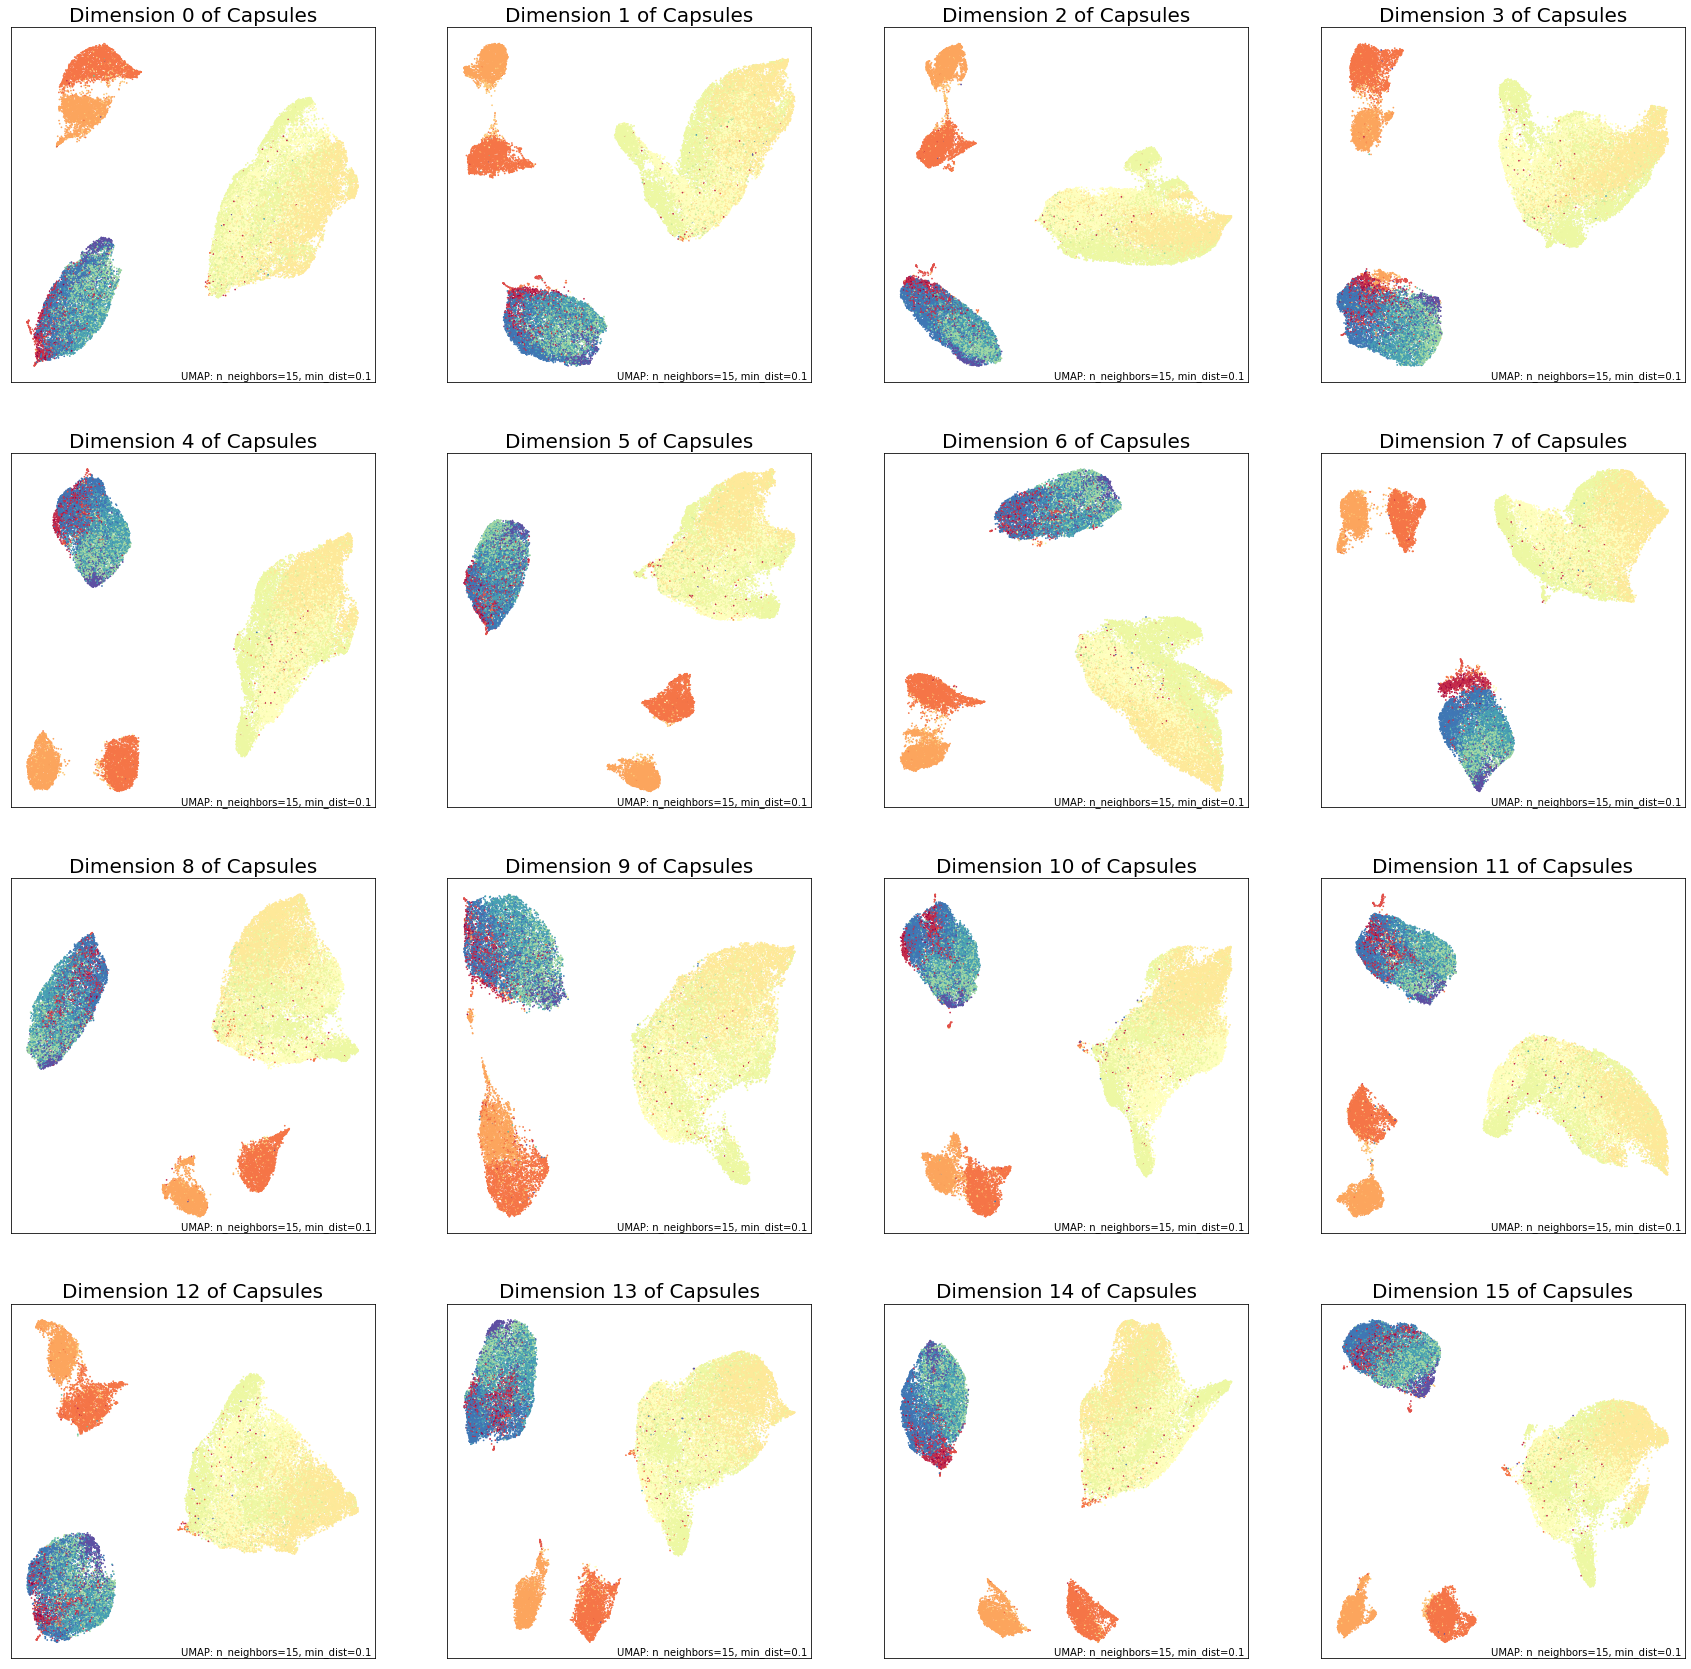

In [36]:
fig = plt.figure(figsize=(30,30))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    umap.plot.points(mappers[i], labels=meta[str(2)].values,ax=ax)
    ax.get_legend().remove()
    plt.title('Dimension '+str(i)+' of Capsules',fontdict={'fontsize': 20})
    
# fig.savefig('./figures/umap_Cap16D_cellstate.png',dpi=100)
plt.show()

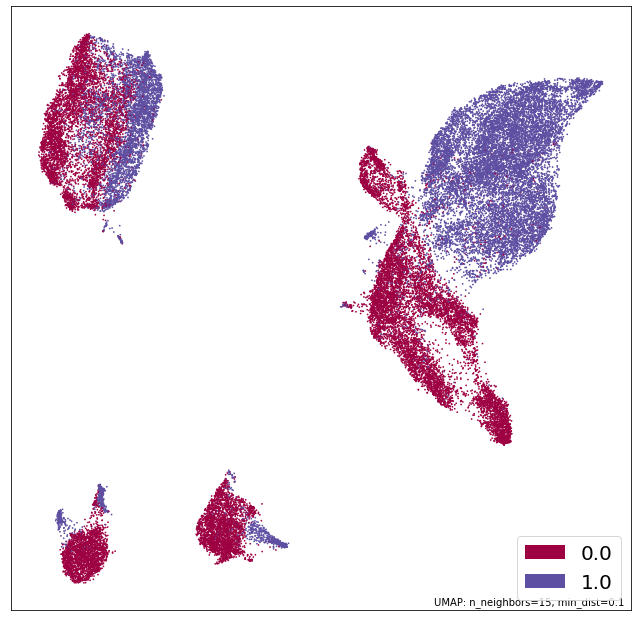

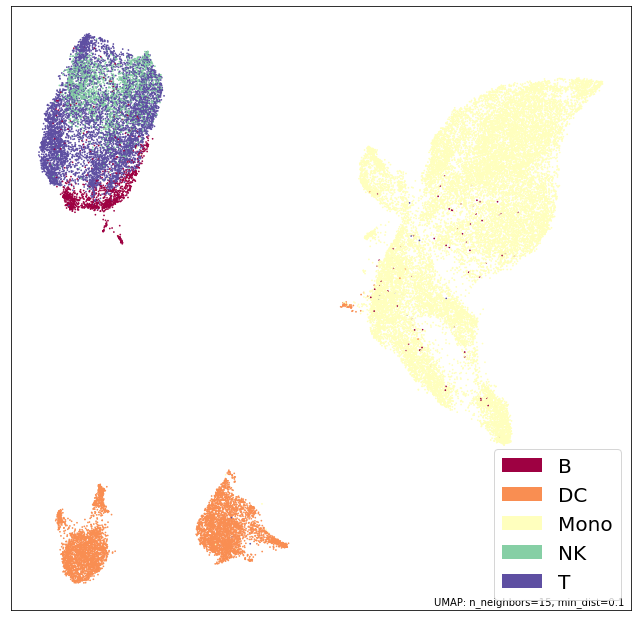

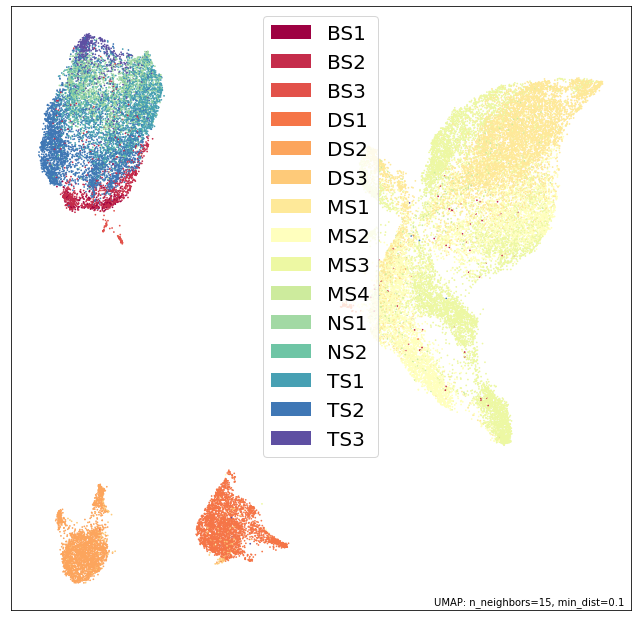

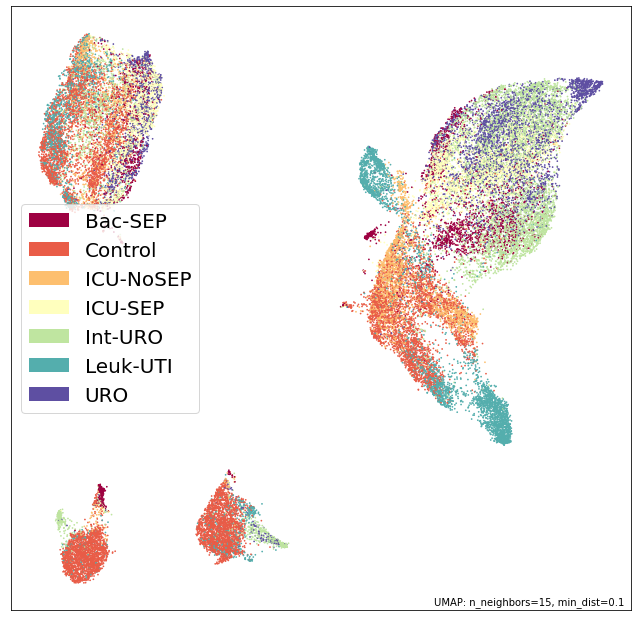

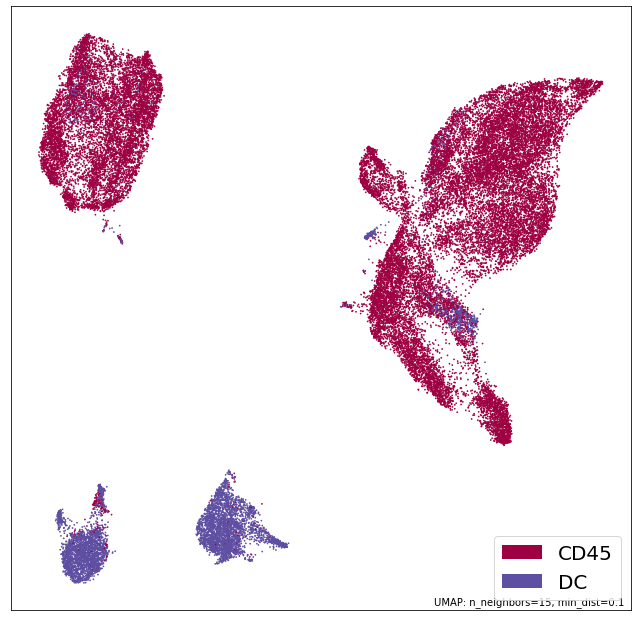

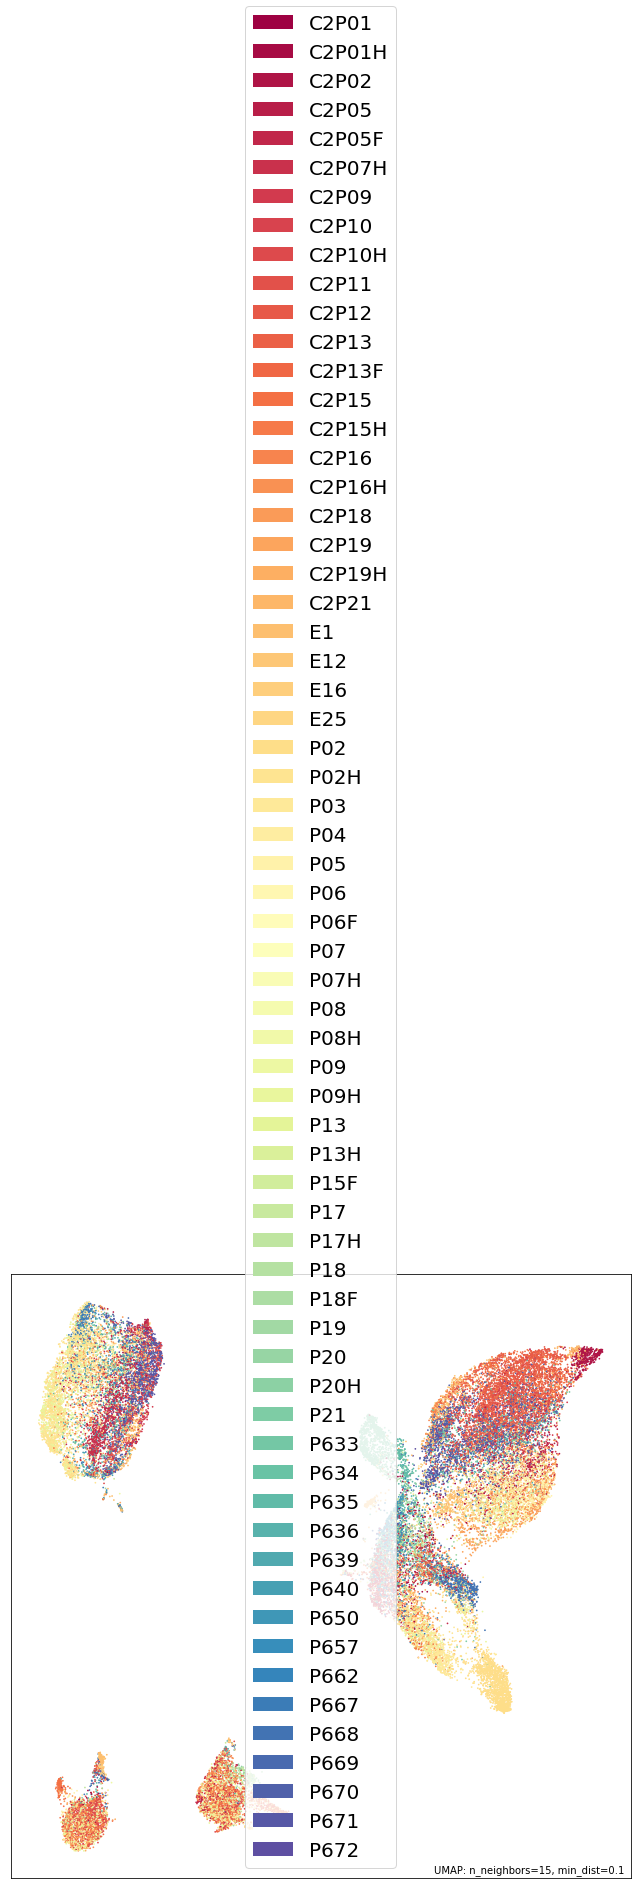

In [37]:
capsOutput = res.reshape(len(res),-1)
mapper = umap.UMAP().fit(capsOutput)
umap.plot.points(mapper, labels=y_train.squeeze())

for i in range(1,6):
    umap.plot.points(mapper, labels=meta[str(i)].values)